# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 10
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 13th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Name: Christopher Hase

In [502]:
import numpy as np
import pymc3 as pm
from pymc3 import summary, sample_ppc
import sklearn.model_selection
import pandas as pd
import scipy
from matplotlib import pyplot as plt

## Problem #1: Iris Eyes Are Smiling

This Homework problem is a continuation of Problem #4 from Homework 8.  We'll be using the same iris dataset. The iris data can be obtained [here](./iris.csv).

Now that we have from Homework 8 Problem #4 a train-test split as well as point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

** *Note this next section is just guidance and doesn't contain any work for you to do* **

*There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

*There are multiple ways in which you can do these probability estimates at a sample $x$:*

(A) You can just use a point estimate like the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

** *Note this next section contains the tasks we expect you to complete* **


1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?


In [3]:
# read in data, format, and view
iris = pd.read_csv('iris.csv')
iris = pd.get_dummies(iris).iloc[:, [0,1,2,3,6]]
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'virginica']
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,virginica
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# get train, test split
train, test = sklearn.model_selection.train_test_split(iris, test_size = 0.4, train_size=0.6, 
                                                       random_state=1, 
                                                       stratify=iris['virginica'])

In [5]:
# bayesian logit
with pm.Model() as bayes_logit:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10),
              'sepal_length': pm.Normal.dist(mu=0, sd = 10),
              'sepal_width': pm.Normal.dist(mu=0, sd = 10),
              'petal_length': pm.Normal.dist(mu=0, sd = 10),
              'petal_width': pm.Normal.dist(mu=0, sd = 10)}
    
    pm.glm.GLM.from_formula('virginica ~ sepal_length + sepal_width + petal_length + petal_width', 
                            train, family = pm.glm.families.Binomial(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    bayes_logit_trace = pm.sampling.sample(draws = 20000, step = step, init = 'advi',
                                           compute_convergence_checks = False, chains = 1, tuning = 10000,
                                           target_accept=0.95)

Sequential sampling (1 chains in 1 job)
NUTS: [petal_width, petal_length, sepal_width, sepal_length, Intercept]
100%|██████████| 20500/20500 [08:04<00:00, 42.31it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
# posterior predictive for training points
with bayes_logit:
    pp_samples = pm.sample_ppc(bayes_logit_trace, samples = 20000)

100%|██████████| 20000/20000 [00:15<00:00, 1320.19it/s]


### Part 1

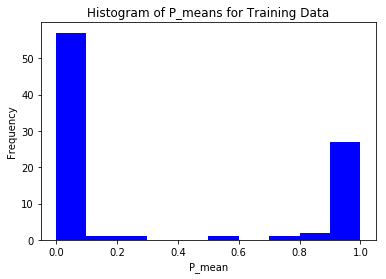

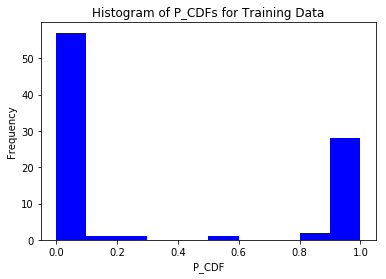

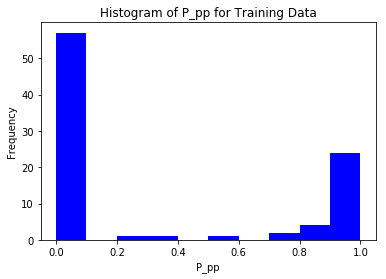

In [211]:
# compute pmean, pcdf, and Ppp values and create histograms
pmean_train = scipy.special.expit(np.dot(np.concatenate([np.ones((len(train), 1)),train.iloc[:, :-1].values], axis=1),\
              summary(bayes_logit_trace)['mean'].values))

var_names = ['Intercept', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']
beta_arrays = []
for var in var_names:
    beta_arrays.append(bayes_logit_trace[var].reshape(len(bayes_logit_trace[var]), -1))
beta_matrix = np.concatenate(beta_arrays, axis=1)
pcdf_invlogit_train = scipy.special.expit(np.dot(beta_matrix,\
                    np.concatenate([np.ones((len(train), 1)),train.iloc[:, :-1].values], axis=1).T))
pcdf_train = np.mean(pcdf_invlogit_train > 0.5, axis = 0)

Ppp_train = np.mean(pp_samples['y'], axis=0)

plt.hist(pmean_train, color ='blue', density=False)
plt.title('Histogram of P_means for Training Data')
plt.xlabel('P_mean')
plt.ylabel('Frequency')
plt.show()

plt.hist(pcdf_train, color ='blue', density=False)
plt.title('Histogram of P_CDFs for Training Data')
plt.xlabel('P_CDF')
plt.ylabel('Frequency')
plt.show()

plt.hist(Ppp_train, color ='blue', density=False)
plt.title('Histogram of P_pp for Training Data')
plt.xlabel('P_pp')
plt.ylabel('Frequency')
plt.show()

The plots of the distributions of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set are quite similar.

### Parts 2 and 3

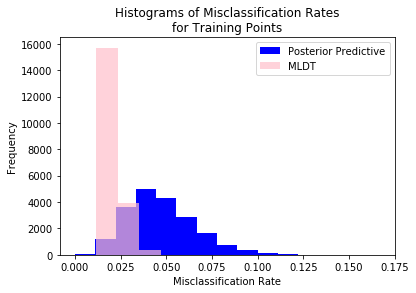

In [491]:
# plotting misclassification rates for posterior predicitive and MLDT (train)
plt.hist(np.mean((train['virginica'].values - pp_samples['y'])**2, axis=1), color='blue', bins = 15)
plt.hist(np.mean((train['virginica'].values - pcdf_invlogit_train)**2, axis=1), color='pink', bins = 4, alpha=0.7)
plt.title('Histograms of Misclassification Rates\nfor Training Points')
plt.xlabel('Misclassification Rate')
plt.ylabel('Frequency')
plt.legend(loc = 'upper right', labels = ['Posterior Predictive', 'MLDT'])
plt.show()

The misclassification distribution from the posterior predictive is wider.

### Part 4

In [467]:
# counting number and proportion of perfect bitstrings in terms of train classifications
print('Number of perfect bitstrings in posterior predictive trace: ' + str(np.sum(np.mean((train['virginica'].values - pp_samples['y'])**2, axis=1) == 0)))
print('Proportion of perfect bitstrings in posterior predictive trace: ' + str(np.sum(np.mean((train['virginica'].values - pp_samples['y'])**2, axis=1) == 0)/20000))
rows_str_list = []
for row in pp_samples['y']:
    rows_str_list.append(str(row))
print('Number of times most frequent bitstring occurs: ' + str(np.max(np.unique(rows_str_list, return_counts=True)[1])))

Number of perfect bitstrings in posterior predictive trace: 54
Proportion of perfect bitstrings in posterior predictive trace: 0.0027
Number of times most frequent bitstring occurs: 1093


The training points are all predicted correctly 0.27% of the time. There are other training point prediction configurations that occur more frequently than the one that is perfectly accurate. The probability that a particular sample of predictions for the training points from the posterior predictive will have perfect accuracy is low even if the model is well specified.

### Part 5

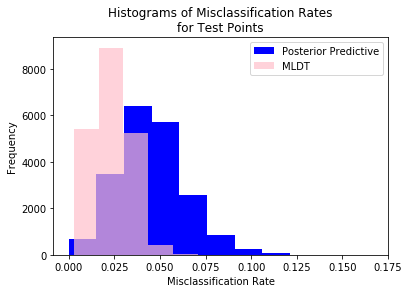

In [484]:
# plotting misclassification rates for posterior predicitive and MLDT (test)
var_names = ['Intercept', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']
beta_arrays = []
for var in var_names:
    beta_arrays.append(bayes_logit_trace[var].reshape(len(bayes_logit_trace[var]), -1))
beta_matrix = np.concatenate(beta_arrays, axis=1)
pcdf_invlogit_test = scipy.special.expit(np.dot(beta_matrix,\
                    np.concatenate([np.ones((len(test), 1)),test.iloc[:, :-1].values], axis=1).T))
pcdf_test = np.mean(pcdf_invlogit_test > 0.5, axis = 0)

plt.hist(np.mean((test['virginica'].values - np.random.binomial(1, pcdf_invlogit_test, size = pcdf_invlogit_test.shape))**2, axis=1), color='blue', bins=11)
plt.hist(np.mean((test['virginica'].values - pcdf_invlogit_test)**2, axis=1), color='pink', alpha=0.7, bins = 6)
plt.title('Histograms of Misclassification Rates\nfor Test Points')
plt.xlabel('Misclassification Rate')
plt.ylabel('Frequency')
plt.legend(loc = 'upper right', labels = ['Posterior Predictive', 'MLDT'])
plt.show()

The misclassification distribution from the posterior predictive is wider once again. This is because the variance of the samples being drawn from the posterior predictive will be greater than the variance of the indicators of probabililties computed by drawing betas from the posterior and applying them to the test points being greater than 0.5.

## Problem 2: From the Ritz to the Rubble

In this problem, much like in Long Homework 9, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 
- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school
Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute WAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

In [359]:
# read in, format, and view data
census = pd.read_csv('census_data.csv')
census = census.loc[:, ('edu', 'sex', 'earning')]
census_dum = pd.get_dummies(census)
less_hs = np.sum(census_dum.loc[:, ('edu_10th', 'edu_11th', 'edu_12th', 'edu_1st-4th','edu_5th-6th', 'edu_7th-8th',\
                                    'edu_9th', 'edu_Preschool')].values, axis=1).reshape(len(census), -1)
someColl_assocAcad = np.sum(census_dum.loc[:, ('edu_Assoc-acdm', 'edu_Some-college')].values, axis=1).reshape(len(census), -1)
prof_voc = np.sum(census_dum.loc[:, ('edu_Assoc-voc', 'edu_Prof-school')].values, axis=1).reshape(len(census), -1)
census_mat = np.concatenate([less_hs, someColl_assocAcad, prof_voc, census_dum.loc[:, ('edu_Bachelors','edu_Doctorate',\
                                                                          'edu_HS-grad', 'edu_Masters',\
                                                                          'sex_Female', 'earning_>50K')]], axis = 1)
census = pd.DataFrame(census_mat)
census.columns = ['less_hs', 'someColl_assocAcad', 'prof_voc', 'edu_Bachelors','edu_Doctorate', 'edu_HS',\
                  'edu_Masters', 'sex_Female', 'earn50K']
census_logit = census.iloc[:, 1:]
census.head()

,less_hs,someColl_assocAcad,prof_voc,edu_Bachelors,edu_Doctorate,edu_HS,edu_Masters,sex_Female,earn50K
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0


In [295]:
# bayesian logit; no education, no gender
with pm.Model() as logit_noEduc_noGender:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10)}
    
    pm.glm.GLM.from_formula('earn50K ~ 1', census, family = pm.glm.families.Binomial(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    noEduc_noGender_trace = pm.sampling.sample(draws = 2000, step = step, init = 'advi',
                                           compute_convergence_checks = False, chains = 1, tuning = 10000,
                                           target_accept=0.9)

Sequential sampling (1 chains in 1 job)
NUTS: [Intercept]
100%|██████████| 2500/2500 [01:17<00:00, 32.15it/s]


In [293]:
# bayesian logit; no education, gender
with pm.Model() as logit_noEduc_gender:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10),
              'sex_Female': pm.Normal.dist(mu=0, sd=10)}
    
    pm.glm.GLM.from_formula('earn50K ~ sex_Female', census, family = pm.glm.families.Binomial(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    noEduc_gender_trace = pm.sampling.sample(draws = 2000, step = step, init = 'advi',
                                           compute_convergence_checks = False, chains = 1, tuning = 10000,
                                           target_accept=0.90)

Sequential sampling (1 chains in 1 job)
NUTS: [sex_Female, Intercept]
100%|██████████| 2500/2500 [02:17<00:00, 18.15it/s]


In [380]:
# get WAIC
def make_compare(names, traces, models, ic='WAIC'):
    comparedf = pm.compare(traces, models, method='pseudo-BMA')
    temp = comparedf.sort_index()
    temp['Model'] = names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf
 
names = ['Intercept only', 'Gender']
dfc = make_compare(names, [noEduc_noGender_trace, noEduc_gender_trace],[logit_noEduc_noGender, logit_noEduc_gender])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
Gender,34274.1,1.95,0,1,181.78,0,0
Intercept only,35949.9,0.91,1675.8,0,177.2,76.35,0


In [506]:
# sample from posterior for no educ, gender model
with logit_noEduc_gender:
    noEduc_gender_pp = sample_ppc(noEduc_gender_trace, samples = 10000)

100%|██████████| 10000/10000 [01:50<00:00, 90.30it/s]


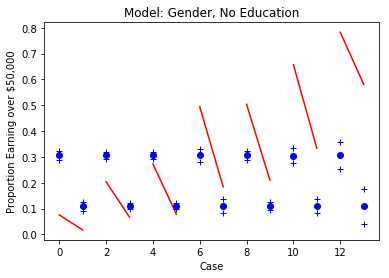

In [509]:
# produce plot like figure 10.5
edu_names_ordered = ['less_hs', 'edu_HS', 'someColl_assocAcad', 'prof_voc', 'edu_Bachelors', 'edu_Masters',\
                     'edu_Doctorate']
male_props_by_edu = []
female_props_by_edu = []
pred_male_props_by_edu = []
pred_female_props_by_edu = []
std_pred_male_props_by_edu = []
std_pred_female_props_by_edu = []
for col in edu_names_ordered:
    for gender in [0, 1]:
        census_current = census[(census[col] == 1) & (census['sex_Female'] == gender)]
        if gender == 0:
            male_props_by_edu.append(census_current['earn50K'].mean())
            pred_matrix = noEduc_gender_pp['y'].T[census_current.index]
            pred_male_props_by_edu.append(np.mean(pred_matrix))
            std_pred_male_props_by_edu.append(np.std(np.mean(pred_matrix, axis=0), ddof=1))
        elif gender == 1:
            female_props_by_edu.append(census_current['earn50K'].mean())
            pred_matrix = noEduc_gender_pp['y'].T[census_current.index]
            pred_female_props_by_edu.append(np.mean(pred_matrix))
            std_pred_female_props_by_edu.append(np.std(np.mean(pred_matrix, axis=0), ddof=1))
            
for i in range(len(edu_names_ordered)):
    plt.plot(np.arange(2*i, 2+2*i), [male_props_by_edu[i], female_props_by_edu[i]], 'r')
    plt.plot(np.arange(2*i, 2+2*i), [pred_male_props_by_edu[i], pred_female_props_by_edu[i]], marker='o', color='blue', linestyle='None')
    plt.plot(np.arange(2*i, 2+2*i), [pred_male_props_by_edu[i]+2*std_pred_male_props_by_edu[i], pred_female_props_by_edu[i]+2*std_pred_female_props_by_edu[i]], linestyle = 'None', marker='+', color='blue')
    plt.plot(np.arange(2*i, 2+2*i), [pred_male_props_by_edu[i]-2*std_pred_male_props_by_edu[i], pred_female_props_by_edu[i]-2*std_pred_female_props_by_edu[i]], linestyle = 'None', marker='+', color='blue')
plt.title('Model: Gender, No Education')
plt.ylabel('Proportion Earning over $50,000')
plt.xlabel('Case')
plt.show()

Case 0: Male, some HS or less

Case 1: Female, some HS or less

Case 2: Male, HS

Case 3: Female, HS

Case 4: Male, some college or academic associates degree

Case 5: Female, some college or academic associates degree

Case 6: Male, professional or vocational school

Case 7: Female, professional or vocational school

Case 8: Male, Bachelor's degree

Case 9: Female, Bachelor's

Case 10: Male, Master's degree

Case 11: Female, Master's degree

Case 12: Male, Doctorate

Case 13: Female, Doctorate

Red lines: Observed proportions of those earning over $50,000

Blue dots: Sample means of posterior predictive samples

Blue pluses: 2-sigma bounds for sample means of posterior predictive samples

The WAIC values indicate that gender is an important variable in predicting earnings over \$50,000. The model fit indicates that males are more likely to earn over \$50,000 than females and that the difference in the probability that a male earns over \$50,000 and the probability that a female earns over \$50,000 is the same for each level of education. However, the plot shows that this difference varies by education level in the observed data, implying that the model is not well specified.

In [298]:
# bayesian logit; education, no gender
with pm.Model() as logit_educ_noGender:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10),
              'someColl_assocAcad': pm.Normal.dist(mu=0, sd=10),
              'prof_voc': pm.Normal.dist(mu=0, sd=10),
              'edu_Bachelors': pm.Normal.dist(mu=0, sd=10),
              'edu_Doctorate': pm.Normal.dist(mu=0, sd=10),
              'edu_HS': pm.Normal.dist(mu=0, sd=10),
              'edu_Masters': pm.Normal.dist(mu=0, sd=10)}
    
    pm.glm.GLM.from_formula('earn50K ~ someColl_assocAcad+prof_voc+edu_Bachelors+edu_Doctorate+edu_HS+edu_Masters',\
                            census, family = pm.glm.families.Binomial(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    educ_noGender_trace = pm.sampling.sample(draws = 2000, step = step, init = 'advi',
                                           compute_convergence_checks = False, chains = 1, tuning = 10000,
                                           target_accept=0.90)

Sequential sampling (1 chains in 1 job)
NUTS: [edu_Masters, edu_HS, edu_Doctorate, edu_Bachelors, prof_voc, someColl_assocAcad, Intercept]
100%|██████████| 2500/2500 [05:14<00:00,  7.95it/s]


In [314]:
# bayesian logit; education, gender
with pm.Model() as logit_educ_gender:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10),
              'someColl_assocAcad': pm.Normal.dist(mu=0, sd=10),
              'prof_voc': pm.Normal.dist(mu=0, sd=10),
              'edu_Bachelors': pm.Normal.dist(mu=0, sd=10),
              'edu_Doctorate': pm.Normal.dist(mu=0, sd=10),
              'edu_HS': pm.Normal.dist(mu=0, sd=10),
              'edu_Masters': pm.Normal.dist(mu=0, sd=10),
              'sex_Female': pm.Normal.dist(mu=0, sd=10)}
    
    pm.glm.GLM.from_formula('earn50K ~ someColl_assocAcad+prof_voc+edu_Bachelors+edu_Doctorate+edu_HS+edu_Masters+sex_Female',
                            census, family = pm.glm.families.Binomial(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    educ_gender_trace = pm.sampling.sample(draws = 2000, step = step, init = 'advi',
                                           compute_convergence_checks = False, chains = 1, tuning = 10000,
                                           target_accept=0.90)

Sequential sampling (1 chains in 1 job)
NUTS: [sex_Female, edu_Masters, edu_HS, edu_Doctorate, edu_Bachelors, prof_voc, someColl_assocAcad, Intercept]
100%|██████████| 2500/2500 [04:03<00:00, 10.28it/s]
The acceptance probability does not match the target. It is 0.879089710495, but should be close to 0.8. Try to increase the number of tuning steps.


In [315]:
# get WAIC
names = ['educ', 'educ and gender']
dfc = make_compare(names, [educ_noGender_trace, educ_gender_trace],[logit_educ_noGender, logit_educ_gender])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
educ and gender,30428.6,8.05,0,1,196.08,0,0
educ,32151.5,6.85,1722.92,0,193.03,77.93,0


In [507]:
# sample from posterior for educ, gender model
with logit_educ_gender:
    educ_gender_pp = sample_ppc(educ_gender_trace, samples = 10000)

100%|██████████| 10000/10000 [02:16<00:00, 73.34it/s]


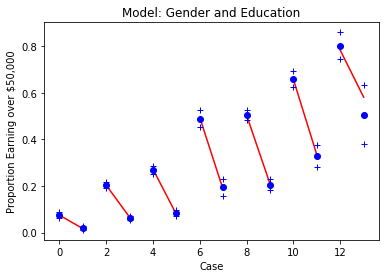

In [516]:
# produce plot like figure 10.6
edu_names_ordered = ['less_hs', 'edu_HS', 'someColl_assocAcad', 'prof_voc', 'edu_Bachelors', 'edu_Masters',\
                     'edu_Doctorate']
male_props_by_edu = []
female_props_by_edu = []
pred_male_props_by_edu = []
pred_female_props_by_edu = []
std_pred_male_props_by_edu = []
std_pred_female_props_by_edu = []
for col in edu_names_ordered:
    for gender in [0, 1]:
        census_current = census[(census[col] == 1) & (census['sex_Female'] == gender)]
        if gender == 0:
            male_props_by_edu.append(census_current['earn50K'].mean())
            pred_matrix = educ_gender_pp['y'].T[census_current.index]
            pred_male_props_by_edu.append(np.mean(np.mean(pred_matrix, axis=0)))
            std_pred_male_props_by_edu.append(np.std(np.mean(pred_matrix, axis=0), ddof=1))
        elif gender == 1:
            female_props_by_edu.append(census_current['earn50K'].mean())
            pred_matrix = educ_gender_pp['y'].T[census_current.index]
            pred_female_props_by_edu.append(np.mean(np.mean(pred_matrix, axis=0)))
            std_pred_female_props_by_edu.append(np.std(np.mean(pred_matrix, axis=0), ddof=1))
            
for i in range(len(edu_names_ordered)):
    plt.plot(np.arange(2*i, 2+2*i), [male_props_by_edu[i], female_props_by_edu[i]], 'r')
    plt.plot(np.arange(2*i, 2+2*i), [pred_male_props_by_edu[i], pred_female_props_by_edu[i]], marker='o', color='blue', linestyle='None')
    plt.plot(np.arange(2*i, 2+2*i), [pred_male_props_by_edu[i]+2*std_pred_male_props_by_edu[i], pred_female_props_by_edu[i]+2*std_pred_female_props_by_edu[i]], linestyle = 'None', marker='+', color='blue')
    plt.plot(np.arange(2*i, 2+2*i), [pred_male_props_by_edu[i]-2*std_pred_male_props_by_edu[i], pred_female_props_by_edu[i]-2*std_pred_female_props_by_edu[i]], linestyle = 'None', marker='+', color='blue')
plt.title('Model: Gender and Education')
plt.ylabel('Proportion Earning over $50,000')
plt.xlabel('Case')
plt.show()

Case 0: Male, some HS or less

Case 1: Female, some HS or less

Case 2: Male, HS

Case 3: Female, HS

Case 4: Male, some college or academic associates degree

Case 5: Female, some college or academic associates degree

Case 6: Male, professional or vocational school

Case 7: Female, professional or vocational school

Case 8: Male, Bachelor's degree

Case 9: Female, Bachelor's

Case 10: Male, Master's degree

Case 11: Female, Master's degree

Case 12: Male, Doctorate

Case 13: Female, Doctorate

Red lines: Observed proportions of those earning over $50,000

Blue dots: Sample means of posterior predictive samples

Blue pluses: 2-sigma bounds for sample means of posterior predictive samples

The WAIC values indicate that gender is an important variable in predicting earnings over \$50,000, even after controlling for education level. The model fit indicates that males are more likely to earn over \$50,000 than females and that the difference in the probability that a male earns over \$50,000 and the probability that a female earns over \$50,000 varies by level of education. The plot shows that this difference varies by education level in the observed data and that the model is much more well specified than when not accounting for education level.